# 인기대여소(대여소별 이용횟수)와 고장의 연관성 분석

In [127]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

## 데이터 로드 및 전처리

In [128]:
df_rent = pd.read_csv("training_data7~12.csv")
df_office = pd.read_csv("서울특별시 공공자전거 대여소별 이용정보(월별)_22.7-22.12.csv")

In [129]:
import re

# 기준년월 열을 datetime 타입으로 변환
df_office['기준년월'] = pd.to_datetime(df_office['기준년월'], format="%Y%m")

# 대여소명에서 숫자만 추출하여 int 타입으로 변환
df_office['대여소명'] = df_office['대여소명'].str.extract('(\d+)').astype(int)

# 숫자 이외의 문자 제거하고 int 타입으로 변환하는 함수
def remove_non_digits_and_convert_to_int(value):
    cleaned_value = re.sub('[^0-9]', '', value)
    return int(cleaned_value) if cleaned_value else 0

# 대여건수와 반납건수에서 숫자 이외의 문자 제거 및 int 타입으로 변환
df_office['대여건수'] = df_office['대여건수'].apply(remove_non_digits_and_convert_to_int)
df_office['반납건수'] = df_office['반납건수'].apply(remove_non_digits_and_convert_to_int)
df_office.head()

,자치구,대여소명,기준년월,대여건수,반납건수
0,강남구,2301,2022-07-01,2170,2183
1,강남구,2302,2022-07-01,1140,1143
2,강남구,2303,2022-07-01,1329,1196
3,강남구,2304,2022-07-01,288,104
4,강남구,2305,2022-07-01,334,342


## 인기대여소, 비인기대여소 추출

- **`인기대여소`** : 사람들의 이용이 많은 상위 100개 대여소

- **`비인기대여소`** : 사람들의 이용이 적은 하위 1000개 대여소

위와 같은 비율로 해야 데이터 수가 비슷합니다.

대여와 반납이 모두 인기대여소(비인기대여소) 에 속한 대여이력을 추출하였습니다.

In [130]:
# 대여소명으로 묶어 대여건수와 반납건수 합산
df_grouped = df_office.groupby('대여소명').agg({'대여건수': 'sum', '반납건수': 'sum'}).reset_index()
# '이용건수' 열 추가
df_grouped['이용건수'] = df_grouped['대여건수'] + df_grouped['반납건수']
df_grouped = df_grouped.sort_values(by='이용건수', ascending=False)

popular = df_grouped.head(100) # 인기대여소 상위 100개
unpopular = df_grouped.tail(1000) # 인기없는 대여소 하위 1000개
popular.head()

,대여소명,대여건수,반납건수,이용건수
1779,2715,91592,91343,182935
335,502,70875,76086,146961
2298,4217,69091,73901,142992
90,207,64875,60514,125389
865,1210,62099,61961,124060


In [131]:
popular_stations = popular['대여소명'].tolist()
# df_rent에서 대여와 반납이 popular_stations에 속한 행만 추출
popular_rent = df_rent[df_rent['대여 대여소번호'].isin(popular_stations) & df_rent['반납대여소번호'].isin(popular_stations)]

# 결과 출력
print("대여와 반납이 인기 상위 100개 대여소에서 이루어진 대여이력 개수 :",len(popular_rent))

broken = popular_rent[popular_rent['고장'] == 1]
normal = popular_rent[popular_rent['고장'] == 0]

print(f"고장 {len(broken)}개,  정상 {len(normal)}개")

대여와 반납이 인기 상위 100개 대여소에서 이루어진 대여이력 개수 : 739
고장 414개,  정상 325개


In [132]:
unpopular_stations = unpopular['대여소명'].tolist()
# df_rent에서 대여와 반납이 unpopular_stations에 속한 행만 추출
unpopular_rent = df_rent[df_rent['대여 대여소번호'].isin(unpopular_stations) & df_rent['반납대여소번호'].isin(unpopular_stations)]

print("대여와 반납이 인기 하위 1000개 대여소에서 이루어진 대여이력 개수 :", len(unpopular_rent))

broken2 = unpopular_rent[unpopular_rent['고장'] == 1]
normal2 = unpopular_rent[unpopular_rent['고장'] == 0]

print(f"고장 {len(broken2)}개,  정상 {len(normal2)}개")

대여와 반납이 인기 하위 1000개 대여소에서 이루어진 대여이력 개수 : 831
고장 358개,  정상 473개


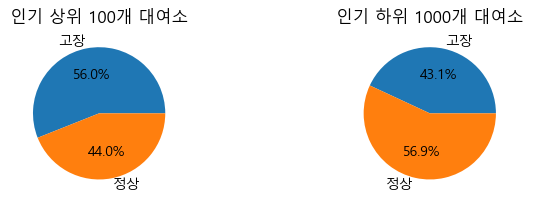

In [133]:
labels = ['고장', '정상']

fig, axs = plt.subplots(1, 2)

axs[0].pie([len(broken), len(normal)], labels=labels, autopct='%1.1f%%')
axs[0].set_aspect('equal')
axs[0].set_title('인기 상위 100개 대여소')

axs[1].pie([len(broken2), len(normal2)], labels=labels, autopct='%1.1f%%')
axs[1].set_aspect('equal')
axs[1].set_title('인기 하위 1000개 대여소')

plt.subplots_adjust(wspace=1)

plt.show()

## 분석결과 및 해석

**인기대여소에서 대여 반납이 이루어진 데이터들은 고장이 정상보다 많았고, 반대로 비인기대여소는 정상이 훨씬 많았습니다.**

아무래도 인기 대여소 주변은 자전거가 많고 혼잡하여 고장이 더 잦다고 추측해 볼 수 있겠습니다.

하지만 이전에 했던 대여소명과 고장의 연관성 분석에서 '광장', '광화문'등 사람들이 많아 혼잡하다고 여겨지는 곳 주변은 고장이 오히려 적었습니다.

**'사람'** 이 많은 장소와 **'자전거'** 가 많은 장소는 뭔가 다른 점이 있어보입니다.